In [1]:
from util.MicFileTool import MicFile
import util.Simulation as Gsim
import util.RotRep as Rot
import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage
from scipy import optimize
import json
import os

# Extract the windows around the Bragg Peaks from a small grain

In [2]:
a=MicFile("AuxData/Ti7_WithHRM_2ndLoad_z1_.mic.LBFS")


-0.556875 -0.00974279 0 2 7 1 281.746 88.7135 78.1765 0.145161 0.885753 0.14876 0 1 1 1 0 0 0

<class 'str'>
sw is 0.72 

shape of snp is (32855, 19)


In [3]:
# crystal_file = {'material':'Ti7LP15',
#                 'A':list(2.95*np.array([1,0,0])),
#                'B':list(2.95*np.array([np.cos(np.pi*2/3),np.sin(np.pi*2/3),0])),
#                'C':list(4.7152*np.array([0,0,1])),
#                'atom_pos':[[[1/3.0,2/3.0,1/4.0],22],[[2/3.0,1/3.0,3/4.0],22]]}
# with open('Ti7LP15.json','w') as file:
#     json.dump(crystal_file,file)
    
    
# det_file = {'name':'test',
#                 'psizeJ':0.001454,
#                'psizeK':0.001454,
#                 'pnJ':2048,
#                 'pnK':2048,
#                'J':1182.19,
#                 'K':2026.27,
#                'trans_vec':[7.14503,0,0],
#                'tilt':Rot.EulerZXZ2Mat(np.array([89.1588,87.5647,0.278594])/180.0*np.pi).tolist()}

# with open('det_params.json','w') as file:
#     json.dump(det_file,file)

In [4]:
############ Experimental Parameters ############
crystal_file = 'Ti7LP15.json'
detector_file = 'det_params.json'
energy = 51.9957
etalimit=81/180.0*np.pi
omegaL,omegaU = 0,180


################ grain ID and hexomap output file #############
grain_ID = '55_2nd'
path = 'Calibration_Files/grain_%s/'%grain_ID
grain_pos=np.array([-0.345937, 0.238698, 0])
o_mat=Rot.EulerZXZ2Mat(np.array([97.9141, 90.0041, 259.313])/180.0*np.pi)

################### raw data #######################
raw_data='/mnt/data/sparrow_data/NF-DataSets/2013-07_NF-Strain1/V/Suter_Jul13/NF/Ti7_WithHRM_Under2ndLoad/Ti7_WithHRM_Under2ndLoad__'

if 'grain_%s'%grain_ID not in os.listdir('Calibration_Files/'):
    os.mkdir(path)
    os.mkdir(path+'Ps_bf/')
    os.mkdir(path+'Ps_filtered/')
    
      

In [5]:


# create detector object
Det1=Gsim.Detector(param_file=detector_file)

#create crystal object
crystal_str=Gsim.CrystalStr(cryst_file=crystal_file)
crystal_str.getRecipVec()
crystal_str.getGs(13)


Ps,Gs,Info=Gsim.GetProjectedVertex(Det1,crystal_str,o_mat,etalimit,
                                    grain_pos,getPeaksInfo=True,
                                    omegaL=omegaL,omegaU=omegaU,energy=energy)




In [6]:
# extract window around the Bragg peak on an omega frame
def fetch(ii,pks,fn,offset=0,dx=100,dy=50,verbo=False,more=False,pnx=2048,pny=2048,omega_step=20):
    omegid=int((180-pks[ii,2])*omega_step)+offset
    if omegid<0:
        omegid+=3600
    if omegid>=3600:
        omegid-=3600
    I=plt.imread(fn+'{0:06d}.tif'.format(omegid))
    x1=int((pny-1-pks[ii,0])-dx)
    y1=int(pks[ii,1]-dy)
    if verbo:
        print('y=',pks[ii,1])
        print('x=',pks[ii,0])
    x1=max(0,x1)
    y1=max(0,y1)
    x2=x1+2*dx
    y2=y1+2*dy
    x2=min(x2,pnx)
    y2=min(y2,pny)
    if more:
        return I[y1:y2,x1:x2],(x1,x2,y1,y2,omegid)
    return I[y1:y2,x1:x2]


In [7]:
pks=Ps

In [8]:
dx = 150
dy = 80



for ii in range(len(pks)):
    allpks=[]
    alllims=[]
    totoffset=0
    f,axis=plt.subplots(9,5)
    i=0
    j=0
    for offset in range(totoffset-22,totoffset+23):
        Im,limits=fetch(ii,pks,raw_data,offset,dx=dx,dy=dy,more=True)
        
        if i==9:
            j+=1
            i=0
        axis[i,j].imshow(Im,vmin=0,vmax=30)
        i+=1
        
        allpks.append(Im)
        alllims.append(limits)
        
    f.subplots_adjust(wspace=0,hspace=0)
    f.savefig(path+'Ps_bf/{0:d}.png'.format(ii),dpi=200,bbox_inches='tight')
    plt.close(f)
    allpks=np.array(allpks)
    alllims=np.array(alllims)
    np.save(path+'Ps_bf/Im{0:d}'.format(ii),allpks)
    np.save(path+'Ps_bf/limit{0:d}'.format(ii),alllims)

In [9]:
Nfile=len(pks)


Im=[]
flucThresh=4

for ii in range(Nfile):
    Im.append(np.load(path+'Ps_bf/Im{:d}.npy'.format(ii)))
    Im[ii]=Im[ii]-np.median(Im[ii],axis=0) #substract the median
    mask=Im[ii]>flucThresh
    Im[ii]=mask*Im[ii] #make all pixel that below the fluctuation to be zero 

from scipy.signal import convolve2d
mykernel=np.array([[1,1,1],[1,-1,1],[1,1,1]])
# remove hot spot (whose value is higher than the sum of 8 neighbors)
for ii in range(Nfile):
    for jj in range(45):
        mask=convolve2d(Im[ii][jj],mykernel,mode='same')>0
        Im[ii][jj]*=mask
        

mykernel2=np.array([[1,2,1],[2,4,2],[1,2,1]])/16.0
# Smoothing
for ii in range(Nfile):
    for jj in range(45):
        Im[ii][jj]=convolve2d(Im[ii][jj],mykernel2,mode='same')

for ii in range(Nfile):
    np.save(path+'Ps_filtered/Im{:d}'.format(ii),Im[ii].astype('uint16'))

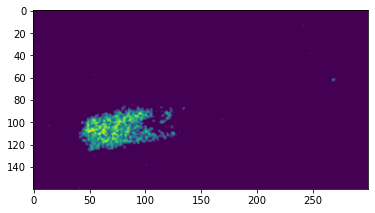

(array([41]),)

In [10]:
idx = 2
a = np.load(path+f'Ps_filtered/Im{idx}.npy')

plt.imshow(a[41,:,:])
plt.show()

maxes = a.sum(axis=(1,2))
np.where(maxes==maxes.max())
            
    

In [11]:
# manually write down the IDs of "good" peaks for calibration

goodidx=np.array([2,4,5,7,8,9,10,12,15,18,
                  19,24,25,26,27,28,29,30,
                  31,32,33,34,35,37,38,39,
                  40,41,43,46,49,50,51,52,
                  53,54,55,56,57,60,63,64,
                  65,66,67,69,70,71,72,73,
                  74,76,77,78,79,81,82,83,
                  84,85,86,87,88,89,90,91,
                  92,93,94,95,
                  36,44,45,62,68,80])

# Find the Center of Mass of each Bragg Peak

In [12]:

# choose one of following two methods to find the center of mass of each "good" Bragg peak.


# can be used even the peak persists on several omega frames
def getCenter1(Im,Omeg1,Omeg2,lower=100,upper=2000):
    blobs, _ = ndimage.label(Im[Omeg1:Omeg2+1])
    _,size=np.unique(blobs,return_counts=True)
    blobID = np.where((size>lower)*(size<upper))[0]
    if len(blobID)==1:
        blobID=blobID[0]
    else:
        print('need manual pick')
        return
    co,cy,cx = ndimage.measurements.center_of_mass(Im[Omeg1:Omeg2+1],blobs,blobID)

    return co,cy,cx

# can be only used on single omega frame
def getCenter2(Im,Omeg,dx=15,dy=7):
    Py,Px=ndimage.measurements.maximum_position(Im[Omeg])
    labels=np.zeros(Im[Omeg].shape,dtype=int)
    labels[Py-dy:Py+dy+1,Px-dx:Px+dx+1]=1
    cy,cx = ndimage.measurements.center_of_mass(Im[Omeg],labels=labels,index=1)
    return Py,Px,cy,cx

(21.28, 8.54, 144.77)


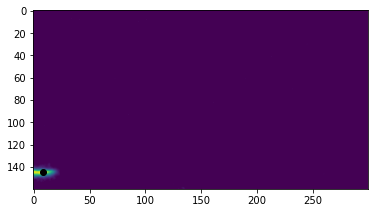

In [13]:
# %matplotlib notebook
tmp=np.load(path+'Ps_filtered/Im88.npy')
bOmeg=21
eOmeg=22

co,cy,cx = getCenter1(tmp,bOmeg,eOmeg,lower=100,upper=1000)
print("({:.2f}, {:.2f}, {:.2f})".format(co+bOmeg,cx,cy))
plt.imshow(np.sum(tmp[bOmeg:eOmeg+1],axis=0))
plt.scatter(cx,cy,c='k')
plt.show()

(21.00, 125.61, 92.52)


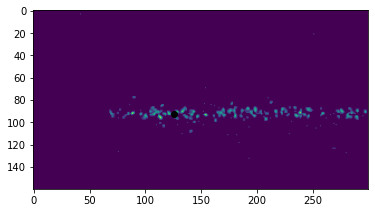

In [14]:
# %matplotlib notebook
tmp=np.load(path+'Ps_filtered/Im94.npy')
Omeg=21
Py,Px,cy,cx = getCenter2(tmp,Omeg,dx=15,dy=5)
print("({:.2f}, {:.2f}, {:.2f})".format(Omeg,cx,cy))
plt.imshow(tmp[Omeg])
plt.scatter(cx,cy,c='k')
plt.show()

# Write down all the center of mass for the good Peaks

In [15]:
# Write down the center of mass of each Bragg Peak, in the order of goodidx
center_of_mass = np.array([(28.79, 161.38, 36.47),
                           (20, 141.56, 51.82),
                           (20.00, 136.09, 52.67),
                           (28.00, 152.87, 54.98),
                           (31.00, 150.29, 56.65),
                           (19.86, 141.39, 56.96),
                           (21.00, 135.42, 55.26),
                           (27.47, 147.29, 57.41),
                           (19.33, 139.94, 59.89),
                           (26.00, 152.22, 58.66),
                           (26.00, 152.82, 60.23),
                           (21.00, 140.49, 63.34),
                           (22.00, 77.09, 63.10),
                           (26.61, 153.50, 67.04),
                           (22.00, 141.62, 66.31),
                           (22.00, 22.54, 66.19),
                           (26.00, 149.67, 67.16),
                           (26.55, 146.24, 67.16),
                           (31.40, 144.80, 69.36),
                           (20.42, 142.44, 68.36),
                           (21.48, 140.41, 68.70),
                           (21.91, 138.86, 68.54),
                           (22.00, 68.60, 68.84),
                           (25.00, 147.25, 68.22),
                           (25.00, 146.93, 68.76),
                           (19.00, 153.14, 71.91),
                           (25.00, 148.87, 68.36),
                           (19.68, 146.27, 72.12),
                           (21.53, 78.33, 70.98),
                           (26.00, 152.47, 72.68),
                           (22.00, 68.98, 70.95),
                           (25.00, 148.49, 73.62),
                           (25.00, 148.11, 74.45),
                           (25.67, 150.38, 75.97),
                           (23.00, 144.00, 72.79),
                           (22.93, 141.36, 73.26),
                           (23.22, 140.70, 74.06),
                           (23.00, 60.33, 73.96),
                           (24.74, 144.38, 74.19),
                           (23.00, 142.72, 75.71),
                           (24.28, 146.32, 74.34),
                           (21.00, 74.10, 78.07),
                           (24.00, 149.06, 74.65),
                           (22.00, 115.61, 77.83),
                           (22.00, 53.23, 76.99),
                           (23.00, 13.56, 74.23),
                           (24.00, 146.26, 77.74),
                           (23.00, 148.08, 75.22),
                           (23.00, 143.69, 75.62),
                           (25.00, 145.35, 77.68),
                           (24.00, 143.52, 77.78),
                           (24.00, 142.50, 77.13),
                           (23.00, 142.20, 77.28),
                           (23.00, 142.62, 77.41),
                           (23.00, 66.54, 77.65),
                           (24.00, 141.78, 77.94),
                           (24.00, 142.46, 78.02),
                           (23.00, 146.43, 77.95),
                           (23.00, 148.30, 78.59),
                           (23.00, 145.70, 78.51),
                           (23.00, 145.49, 78.34),
                           (24.00, 146.21, 78.10),
                           (24.00, 146.66, 78.50),
                           (24.48, 148.78, 79.36),
                           (22.00, 150.51, 75.82),
                           (23.00, 148.37, 76.01),
                           (22.00, 103.28, 76.59),
                           (24.00, 147.77, 78.74),
                           (23.00, 148.90, 76.78),
                           (23.00, 145.66, 76.77),
                           (26.00, 148.64, 67.44),
                           (24.37, 152.98, 69.57),
                           (25.00, 152.38, 71.98),
                           (25.00, 144.92, 74.90),
                           (25.00, 151.22, 76.78),
                           (24.81, 142.24, 77.70)])
# np.save('center_of_mass.npy',center_of_mass)

In [16]:
imgN = len(goodidx)

LimH = np.empty((imgN,5),dtype=np.int32)
good_Gs = Gs[goodidx]
whichOmega = np.empty(imgN,dtype=np.int32)



for ii in range(imgN):
    limit=np.load(path+'Ps_bf/limit{0:d}.npy'.format(goodidx[ii]))
    
    LimH[ii,:]=limit[0]

    if Info[goodidx[ii]]['WhichOmega']=='b':
        whichOmega[ii] = 2
    else:
        whichOmega[ii] = 1

In [17]:
absCOM=np.empty(center_of_mass.shape)
for ii in range(len(absCOM)):
    absCOM[ii,1]=LimH[ii,2]+center_of_mass[ii,2]
    absCOM[ii,0]=2047-(LimH[ii,0]+center_of_mass[ii,1])
    absCOM[ii,2]=(LimH[ii,4]+center_of_mass[ii,0])
    if absCOM[ii,2] >=3600:
        absCOM[ii,2] -= 3600
    absCOM[ii,2] = 180-absCOM[ii,2]*0.05

# Start Calibration

In [18]:
def GetVertex(Det1,Gs,Omegas,orien,etalimit,grainpos,bIdx=True,omegaL=-90,omegaU=90,energy=50):
    Peaks=[]
    rotatedG=orien.dot(Gs.T).T
    for ii in range(len(rotatedG)):
        g1=rotatedG[ii]
        res=Gsim.frankie_angles_from_g(g1,verbo=False,energy=energy)

        if Omegas[ii]==1:
            omega=res['omega_a']/180.0*np.pi
            newgrainx=np.cos(omega)*grainpos[0]-np.sin(omega)*grainpos[1]
            newgrainy=np.cos(omega)*grainpos[1]+np.sin(omega)*grainpos[0]
            idx=Det1.IntersectionIdx(np.array([newgrainx,newgrainy,0]),res['2Theta'],res['eta'],bIdx
                                     ,checkBoundary=False
                                    )

            Peaks.append([idx[0],idx[1],res['omega_a']])

                
        else:
            omega=res['omega_b']/180.0*np.pi
            newgrainx=np.cos(omega)*grainpos[0]-np.sin(omega)*grainpos[1]
            newgrainy=np.cos(omega)*grainpos[1]+np.sin(omega)*grainpos[0]
            idx=Det1.IntersectionIdx(np.array([newgrainx,newgrainy,0]),res['2Theta'],-res['eta'],bIdx
                                    ,checkBoundary=False
                                    )
            Peaks.append([idx[0],idx[1],res['omega_b']])

    Peaks=np.array(Peaks)
    return Peaks

In [19]:
pars={'J':0,'K':0,'L':0,'tilt':(0,0,0),'x':0,'y':0,'distortion':((0,0,0),(0,0,0),(0,0,0))}
DetDefault=Gsim.Detector(psizeJ=0.001454, psizeK=0.001454)

def SimP(x):
    DetDefault.Reset()
    pars['J']=x[0]+1182.19
    pars['K']=x[1]+2026.27
    pars['L']=x[2]*10**(-3)+7.14503
    pars['tilt']=Rot.EulerZXZ2Mat((x[3:6]+np.array([89.1588,87.5647,0.278594]))/180.0*np.pi)
    pars['x']=x[6]*10**(-3)-0.345937
    pars['y']=x[7]*10**(-3)+0.238698
    pars['distortion']=x[8:17].reshape((3,3))*10**(-3)+np.eye(3)
    DetDefault.Move(pars['J'],pars['K'],np.array([pars['L'],0,0]),pars['tilt'])
    pos=np.array([pars['x'], pars['y'], 0])
    Ps=GetVertex(DetDefault,
                    good_Gs,
                    whichOmega,
                    pars['distortion'],
                    etalimit,
                    pos,
                    bIdx=False,
                    omegaL=0,omegaU=180,energy=energy) 
    return Ps

def CostFunc(x):
    Ps = SimP(x)
    weights=np.array((1,5,100))
    tmp=np.sum(((Ps-absCOM)*weights)**2,axis=0)
    return np.sum(tmp)

In [20]:
res=optimize.minimize(CostFunc,np.zeros(17)
                      ,bounds=[(-5,5),(-5,2),(-100,50)]+3*[(-0.3,3)]+2*[(-10,20)]+9*[(-5,10)]
                     )
print(res)

      fun: 497.5866126237406
 hess_inv: <17x17 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.05084075, -0.04588401, -0.02344224, -0.58892055, -0.30861429,
       -1.61728622,  0.18092122,  0.05128413, -0.08977281, -0.06505729,
        0.10445547,  0.03230412,  0.01377884, -0.08586198,  0.17719799,
        0.17075763, -0.19430216])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 11394
      nit: 554
     njev: 633
   status: 0
  success: True
        x: array([-1.94590765e+00, -3.50800883e+00, -8.91343618e+01,  5.34655893e-01,
        2.47994791e+00, -8.82475546e-02,  1.49199694e+01, -2.63017925e+00,
        7.91054683e+00, -5.48537993e-01,  3.54198905e-01,  1.10120828e+00,
        7.49117461e+00,  6.50794125e-01, -6.65259832e-01, -6.26602199e-01,
        8.60900622e+00])


# Check the position of simulated Bragg peaks after calibration

In [21]:
newPs=SimP(res['x'])

In [22]:
oldPs=SimP(np.zeros(17))

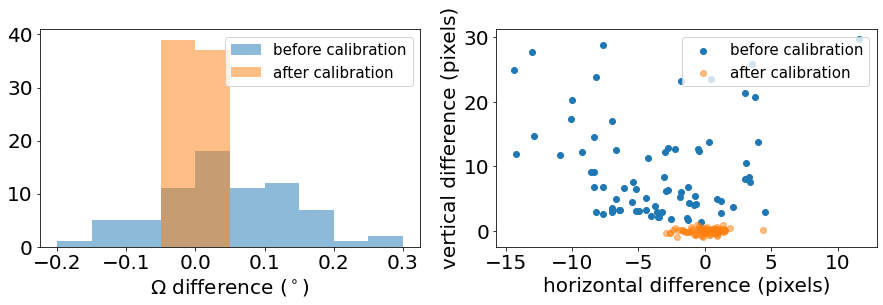

In [23]:
fig,ax=plt.subplots(1,2,figsize=(15,4))
ax[0].hist(oldPs[:,2]-absCOM[:,2],label='before calibration',bins=np.arange(-0.2,0.35,0.05),alpha=0.5)
ax[0].hist(newPs[:,2]-absCOM[:,2],label='after calibration',bins=np.arange(-0.2,0.35,0.05),alpha=0.5)
ax[0].legend(loc='upper right', fontsize=15)
ax[0].set_xlabel(r'$\Omega$ difference $(^\circ)$', fontsize=20)
ax[1].scatter(oldPs[:,0]-absCOM[:,0],oldPs[:,1]-absCOM[:,1],label='before calibration')
ax[1].scatter(newPs[:,0]-absCOM[:,0],newPs[:,1]-absCOM[:,1],label='after calibration',alpha=0.5)
ax[1].set_xlabel('horizontal difference (pixels)', fontsize=20)
ax[1].set_ylabel('vertical difference (pixels)', fontsize=20)
ax[1].legend(loc='upper right', fontsize=15)
ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=20)
plt.savefig('calibration.png',dpi=100,bbox_inches='tight')
plt.show()

# Check the position of simulated Bragg peaks after calibration: Image

In [24]:
x= res['x']

pars={}
pars['J']=x[0]+1182.19
pars['K']=x[1]+2026.27
pars['L']=x[2]*10**(-3)+7.14503
pars['tilt']=Rot.EulerZXZ2Mat((x[3:6]+np.array([89.1588,87.5647,0.278594]))/180.0*np.pi)
pars['x']=x[6]*10**(-3)-0.345937
pars['y']=x[7]*10**(-3)+0.238698
pars['distortion']=x[8:17].reshape((3,3))*10**(-3)+np.eye(3)
DetDefault=Gsim.Detector(psizeJ=0.001454, psizeK=0.001454)
DetDefault.Reset()
DetDefault.Move(pars['J'],pars['K'],np.array([pars['L'],0,0]),pars['tilt'])
pos=np.array([pars['x'], pars['y'], 0])

Ps_new,Gs_new,Info_new=Gsim.GetProjectedVertex(DetDefault,crystal_str,
                                                        pars['distortion'].dot(o_mat),
                                                        etalimit,pos,getPeaksInfo=True,
                                                        omegaL=omegaL,omegaU=omegaU,energy=energy)
print(pars)

{'J': 1180.2440923474867, 'K': 2022.7619911749573, 'L': 7.0558956382061915, 'tilt': array([[ 5.35273770e-03,  7.61463259e-04,  9.99985384e-01],
       [ 9.99980156e-01, -3.32628765e-03, -5.35017683e-03],
       [ 3.32216507e-03,  9.99994178e-01, -7.79252894e-04]]), 'x': -0.331017030558736, 'y': 0.23606782074559335, 'distortion': array([[ 1.00791055e+00, -5.48537993e-04,  3.54198905e-04],
       [ 1.10120828e-03,  1.00749117e+00,  6.50794125e-04],
       [-6.65259832e-04, -6.26602199e-04,  1.00860901e+00]])}


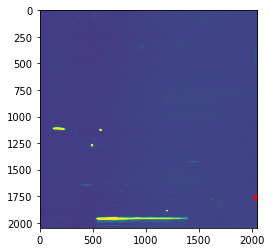

In [25]:
# %matplotlib notebook

# ii is the image ID
ii=86

f,axis=plt.subplots()

omegid=int(round((180-Ps_new[ii,2])*20))
if omegid<0:
    omegid+=3600
if omegid>=3600:
    omegid-=3600
I=plt.imread(raw_data+'{0:06d}.tif'.format(omegid))


axis.imshow(I,vmax=40)
axis.scatter(2047-Ps_new[ii,0],Ps_new[ii,1],c='r')
plt.show()